# Credit Risk & Loan Default Prediction

## Business Objective
The objective of this project is to predict the likelihood of loan default using customer demographic and financial data.  
Financial institutions face significant losses when high-risk applicants default on loans. This project aims to assist lenders in identifying risky borrowers before loan approval, thereby reducing non-performing assets (NPAs).

## Problem Type
This is a supervised machine learning classification problem where:
- `1` represents a loan default
- `0` represents successful loan repayment


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, roc_auc_score, recall_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier


In [2]:
df = pd.read_csv("credit_risk_dataset.csv")
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


## Dataset Overview
The dataset contains customer demographic details, employment information, and loan-related attributes such as loan amount, interest rate, loan grade, and credit history.  
These features are commonly used by banks and NBFCs to assess credit risk.


In [3]:
df.shape

(32581, 12)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [5]:
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


## Data Cleaning & Preprocessing
Real-world financial data often contains missing values.  
Numerical features are imputed using median values, while categorical features are imputed using the most frequent category to preserve data distribution.

In [6]:
df.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [7]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

# Numerical columns → median
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

# Categorical columns → mode
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])


## Exploratory Data Analysis (EDA)
EDA helps understand the distribution of loan defaults and identify relationships between borrower characteristics and default behavior.

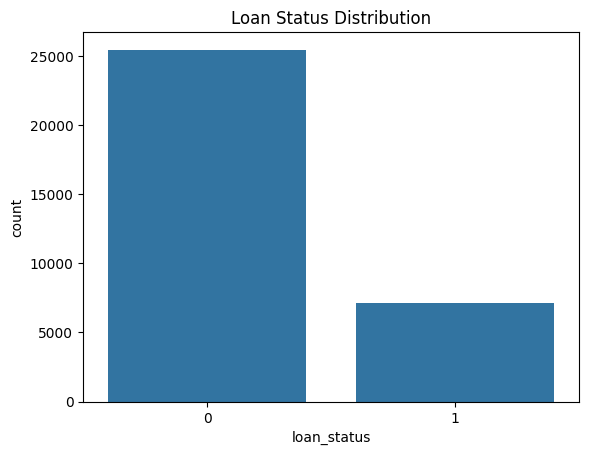

In [ ]:
df['loan_status'].value_counts().plot(kind='bar')
plt.title("Loan Status Distribution")
plt.xlabel("Loan Status (0 = No Default, 1 = Default)")
plt.ylabel("Count")
plt.show()

## Class Imbalance Analysis
In credit risk datasets, default cases are usually fewer than non-default cases.  
This imbalance can bias models toward predicting the majority class, making accuracy a misleading metric.

In [9]:
df['loan_status'].value_counts()

loan_status
0    25473
1     7108
Name: count, dtype: int64

In [10]:
df['loan_status'].value_counts(normalize=True)

loan_status
0    0.781836
1    0.218164
Name: proportion, dtype: float64

In [11]:
oe = OrdinalEncoder()
df[cat_cols] = oe.fit_transform(df[cat_cols])

In [12]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']

## Risk Perspective in Credit Lending
In loan approval systems, misclassifying a defaulter as a safe applicant (false negative) leads to financial loss.  
Therefore, recall for defaulters and ROC-AUC are prioritized over accuracy.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

## Data Leakage Prevention
To ensure reliable model evaluation, the dataset was split into training and testing sets before model training.  
All model fitting and learning steps were performed using only the training data, preventing information from the test set from influencing model performance.

In [14]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Data Preprocessing Approach
The preprocessing steps in this project use median and mode imputation along with ordinal encoding for categorical variables.  
While these techniques are effective for baseline modeling and interpretability, more advanced methods such as target encoding, Weight of Evidence (WoE), or model-based imputation can further improve performance in production-level credit risk systems.

## Model Development
Multiple machine learning models are trained and evaluated:
- Logistic Regression (baseline)
- Random Forest (non-linear model)
- XGBoost (industry-grade boosting model)


In [15]:
lr_model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced'
)

lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

In [16]:
print("Logistic Regression Recall:", recall_score(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_lr))

Logistic Regression Recall: 0.770042194092827
ROC-AUC: 0.7786422942986215


In [17]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    class_weight='balanced',
    random_state=42
)

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

In [18]:
print("Random Forest Recall:", recall_score(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_rf))

Random Forest Recall: 0.729254571026723
ROC-AUC: 0.8439207104397599


## XGBoost Model
XGBoost is widely used in fintech due to its strong performance on structured tabular data and ability to capture complex relationships.

In [19]:
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

In [20]:
print("XGBoost Recall:", recall_score(y_test, y_pred_xgb))
print("XGBoost ROC-AUC:", roc_auc_score(y_test, y_prob_xgb))
print(classification_report(y_test, y_pred_xgb))

XGBoost Recall: 0.7953586497890295
XGBoost ROC-AUC: 0.9469344066119261
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      5095
           1       0.81      0.80      0.80      1422

    accuracy                           0.92      6517
   macro avg       0.88      0.87      0.87      6517
weighted avg       0.91      0.92      0.91      6517



## Why XGBoost Performs Best
XGBoost outperforms baseline models by capturing complex non-linear relationships and feature interactions present in financial risk data.  
Its gradient boosting framework focuses on correcting previous model errors, making it particularly effective for imbalanced classification problems such as loan default prediction.

## Threshold-Based Risk Decision
Instead of a fixed 0.5 threshold, lowering the decision threshold increases recall for defaulters, reducing financial risk.

In [21]:
threshold = 0.4
y_pred_custom = (y_prob_xgb >= threshold).astype(int)

print("Recall at threshold 0.4:", recall_score(y_test, y_pred_custom))

Recall at threshold 0.4: 0.8459915611814346


## Feature Importance Analysis
Understanding important risk drivers improves model interpretability and trust.

In [22]:
importance = pd.Series(
    xgb_model.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

importance.head(10)

loan_grade                   0.301594
loan_percent_income          0.198484
person_home_ownership        0.156885
person_income                0.077836
loan_intent                  0.070913
loan_int_rate                0.053049
cb_person_default_on_file    0.040135
person_emp_length            0.033704
loan_amnt                    0.032372
person_age                   0.019626
dtype: float32

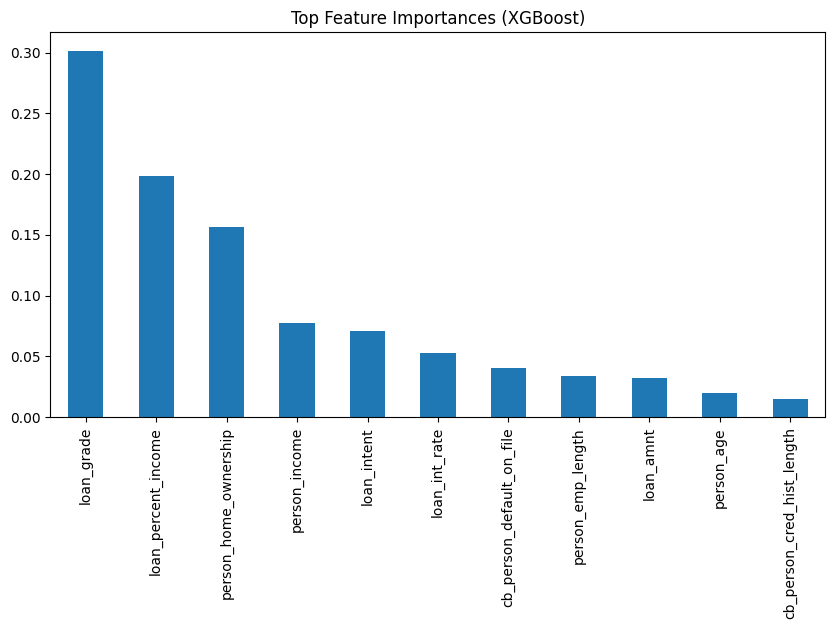

In [23]:
importance.plot(kind='bar', figsize=(10,5))
plt.title("Top Feature Importances (XGBoost)")
plt.show()

## Sample Loan Applicant Prediction
The trained model is tested on a hypothetical applicant to simulate real-world usage.

In [24]:
sample = {
    'person_age': 30,
    'person_income': 55000,
    'person_home_ownership': 1,
    'person_emp_length': 6,
    'loan_intent': 2,
    'loan_grade': 1,
    'loan_amnt': 12000,
    'loan_int_rate': 13.5,
    'loan_percent_income': 0.22,
    'cb_person_default_on_file': 0,
    'cb_person_cred_hist_length': 5
}

sample_df = pd.DataFrame([sample])
sample_df = scaler.transform(sample_df)

pred = xgb_model.predict(sample_df)

print("High Risk (Default)" if pred[0] == 1 else "Low Risk (Safe Loan)")

Low Risk (Safe Loan)


## Conclusion & Business Impact
This project demonstrates an end-to-end credit risk prediction system using machine learning.  
By prioritizing recall and ROC-AUC and using advanced models like XGBoost, the solution helps financial institutions reduce loan default risk, minimize NPAs, and make data-driven lending decisions.
